# Final Project #
### Zhang, Grayson, Teplinski, Hickey ##
### Evaluating micro loans ###

Datasource: <a href="https://www.kaggle.com/husainsb/lendingclub-issued-loans?select=lc_2016_2017.csv">Kaggle - Lending Club</a>

<img src="https://allnigeriabanks.com/wp-content/uploads/2016/11/bank-loan.jpg" style="width: 200px; float:left"/>

Let's kick this thing off. Import libraries. Load file.

In [2]:
# Dependencies
import pandas as pd

%matplotlib inline

import matplotlib.pyplot as plt
from matplotlib import figure

import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix


In [3]:
# Store filepath in a variable
filePath = "lc_2016_2017.csv"

# Read our Data file with the pandas library
data = pd.read_csv(filePath, low_memory = False)

In [4]:
#First let's check all the values in the term column
print(data['term'].value_counts())

#Lets convert these values to integers in case we want to perform math conversions with them
data['term'] = data['term'].str[:2]
data['term'] = data['term'].astype(int)
data.rename(columns = {'term' : 'term (months)'}, inplace = True)

36 months    561237
60 months    198101
Name: term, dtype: int64


Let's also change column 'issue_d'. Right now it is a string of month and year. Let's break that up into a month and year in case we want to evaluate loans over time.

In [5]:
#First let's check all the values in the issue date column
#print(data['issue_d'].value_counts())

#Let's create a new column for issue month
data['issueMonth'] = data['issue_d'].str[:3]

#Let's create a new column for issue year
data['issueYear'] = data['issue_d'].str[4:8]


As our final data preparation step, we want to categorize loans into 'Good' and 'Bad' loans based on their status.

In [12]:
#Let's segment our loans as 'Good' loans or 'Bad' loans
data['loanGoodness'] = np.where(data['loan_status'].str.contains('Current|Fully Paid', regex = True),'Good','Bad')

## Descriptive Analytics ##
This section will explore the dataset so we get a better feel for what the data looks like.

In [9]:
#The below code gives us the number of loans with a certain "loan status"
loanStatus = data['loan_status'].value_counts()
print('\nLoan Status:')
print(loanStatus)

#This code shows us the number of loans with a specific loan grade or rating (A, B, etc.)
loanGrade = data['grade'].value_counts().sort_index()
print('\nLoan Grades:')
print(loanGrade)

#This code shows us the number of loans with a specific loan sub-grade (A1, A2, etc.)
subLoanGrade = data['sub_grade'].value_counts().sort_index()
print('\nLoan Sub Grades:')
print(subLoanGrade)

# This code reveals the number of loans by use of proceeds (i.e. loan "purpose")
purpose = data['purpose'].value_counts().sort_index()
print('\nPurpose:')
print(purpose)

# We investigated the number of loans whose borrowers lived in a particular state
addrState = data['addr_state'].value_counts().sort_index()
print('\nState of origination:')
print(addrState)

# Finally, we found descriptive statistics for the interest rate, loan amount, and Borrower's annual income data
print('\nInterest rate descriptive stats:')
print(data['int_rate'].describe())

print('\nLoan amount descriptive stats:')
print(data['loan_amnt'].describe())

print('\nAnnual income descriptive stats:')
print(data['annual_inc'].describe())


Loan Status:
Current               565523
Fully Paid            130718
Charged Off            37197
Late (31-120 days)     15354
In Grace Period         6634
Late (16-30 days)       3876
Default                   36
Name: loan_status, dtype: int64

Loan Grades:
A    124517
B    230807
C    244903
D     97958
E     41254
F     14362
G      5537
Name: grade, dtype: int64

Loan Sub Grades:
A1    31350
A2    19862
A3    18872
A4    23941
A5    30492
B1    44425
B2    40678
B3    44189
B4    46906
B5    54609
C1    56831
C2    47034
C3    46264
C4    47947
C5    46827
D1    25056
D2    23770
D3    20589
D4    15710
D5    12833
E1    10655
E2     8502
E3     7696
E4     6882
E5     7519
F1     4209
F2     3144
F3     2741
F4     2239
F5     2029
G1     1488
G2     1152
G3     1010
G4      966
G5      921
Name: sub_grade, dtype: int64

Purpose:
car                     8777
credit_card           157768
debt_consolidation    431530
home_improvement       57197
house                   3561
majo

## Diving Deeper ##
One objective of our final project is to explore what factors could be correlated to non-current (i.e. delinquent or defaulted) loans with a late status.

One of our hypotheses is that a loan's purpose will impact "loan status". For example, we expect that people who take out a loan to go on vacation will have a higher non-current rate than people who take a out loans to renovate their home (because the second group is increasing the value of an asset--their house-- that can be used to repay their loan). 

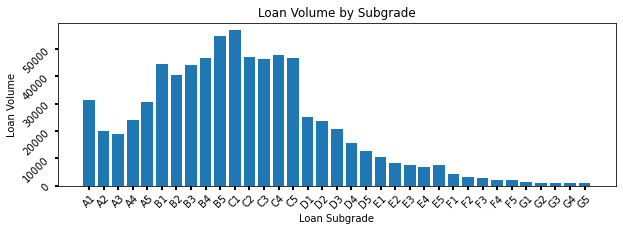

In [10]:
#plotting sub loan grade
plt.figure(figsize=(10, 3)) 
plt.bar(subLoanGrade.index, subLoanGrade.values,align='center')
plt.ylabel('Loan Volume')
plt.xlabel('Loan Subgrade')
plt.title('Loan Volume by Subgrade')
plt.tick_params(labelrotation=45, width=2)

plt.show()

## Exploring Hypothesis 1 ##

loanGoodness   Bad   Good  badnessRate
sub_grade                             
A1             408  30942     0.013014
A2             399  19463     0.020089
A3             451  18421     0.023898
A4             695  23246     0.029030
A5             939  29553     0.030795
B1            1670  42755     0.037591
B2            1820  38858     0.044742
B3            2237  41952     0.050623
B4            2850  44056     0.060760
B5            3632  50977     0.066509
C1            4122  52709     0.072531
C2            4020  43014     0.085470
C3            3856  42408     0.083348
C4            4452  43495     0.092853
C5            4451  42376     0.095052
D1            3369  21687     0.134459
D2            3132  20638     0.131763
D3            2739  17850     0.133032
D4            2537  13173     0.161489
D5            2041  10792     0.159043
E1            2061   8594     0.193430
E2            1667   6835     0.196072
E3            1509   6187     0.196076
E4            1400   5482

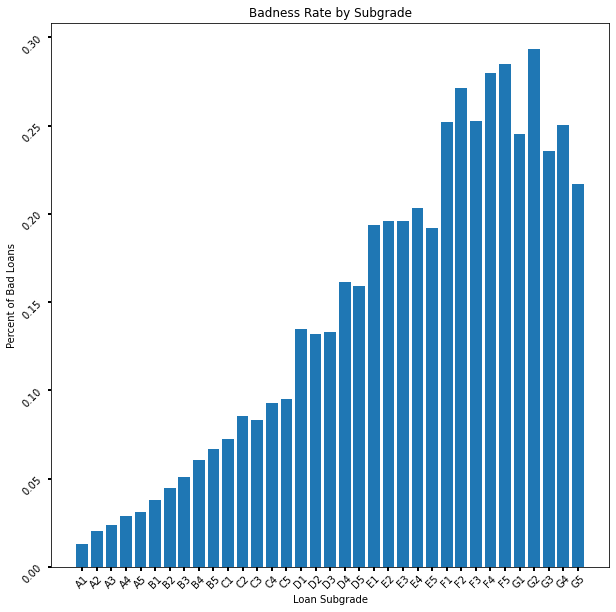

In [13]:
#Source: https://stackoverflow.com/questions/34317149/pandas-groupby-with-bin-counts
subGradeDf = data.groupby(["sub_grade","loanGoodness"])
subGradeDf = subGradeDf.size().unstack()
subGradeDf['badnessRate'] = subGradeDf['Bad']/(subGradeDf['Bad']+subGradeDf['Good'])
print(subGradeDf)


# Bar chart of badness rate by Subgrade
plt.figure(figsize=(10, 10))
plt.bar(subLoanGrade.index, subGradeDf['badnessRate'].values, align='center')
plt.ylabel('Percent of Bad Loans')
plt.xlabel('Loan Subgrade')
plt.title('Badness Rate by Subgrade')
plt.tick_params(labelrotation=45, width=2)
plt.savefig("badness_rate_by_loan_subgrade.png")
#plt.show()

In [14]:
# !!!!! - badness rate v. borrower's income 
data['annual_inc'].describe() 

bins = [0,48000,67000,95000,8900000] 
data['IncomeBin'] = pd.cut(data['annual_inc'],bins)
AnnualIncomeDf = data.groupby(["IncomeBin","loanGoodness"])
AnnualIncomeDf = AnnualIncomeDf.size().unstack() 
AnnualIncomeDf['badnessRate'] = AnnualIncomeDf['Bad']/(AnnualIncomeDf['Bad']+AnnualIncomeDf['Good']) 
AnnualIncomeDf 

loanGoodness,Bad,Good,badnessRate
IncomeBin,,,
"(0, 48000]",18246,178095,0.092930
"(48000, 67000]",16152,169559,0.086974
"(67000, 95000]",15590,173596,0.082406
"(95000, 8900000]",13095,174659,0.069746


## Exploring Hypothesis 2 ##

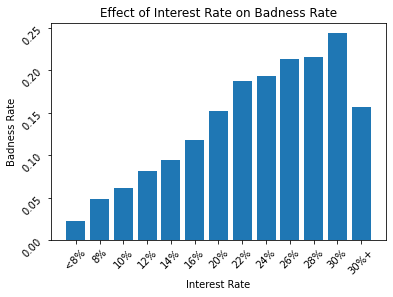

In [15]:
#!!!! - Interest Rate Bins

# First, bin interest rates
data['intRateBin'] = pd.cut(data['int_rate'], bins=[-float('inf'),8,10,12,14,16,18,20,22,24,26,28,30,float('inf')],labels=['<8%','8%','10%','12%','14%','16%','20%','22%','24%','26%','28%','30%','30%+'])

#Second, do some table jockeying to create 'goodness rate'
#Source: https://stackoverflow.com/questions/34317149/pandas-groupby-with-bin-counts
intRateGoodnessDf = data.groupby(["intRateBin","loanGoodness"])
intRateGoodnessDf = intRateGoodnessDf.size().unstack()
intRateGoodnessDf['badnessRate'] = intRateGoodnessDf['Bad']/(intRateGoodnessDf['Bad']+intRateGoodnessDf['Good'])
intRateGoodnessDf.reset_index(inplace=True)

#Third, plot graph.
plt.bar(intRateGoodnessDf['intRateBin'], intRateGoodnessDf['badnessRate'],align='center')
plt.ylabel('Badness Rate')
plt.xlabel('Interest Rate')
plt.title('Effect of Interest Rate on Badness Rate')
plt.tick_params(labelrotation=45)

plt.savefig("intRatevBadnessRate.pdf", bbox_inches="tight")

Let's go further. Using logistic regression, can we create a model that uses exclusively interest rate to predict the badness of a loan.

Model coefficient:
[[-0.1060696]]
Model score (correct prediction):
0.9169052516797527
Confusion Matrix:


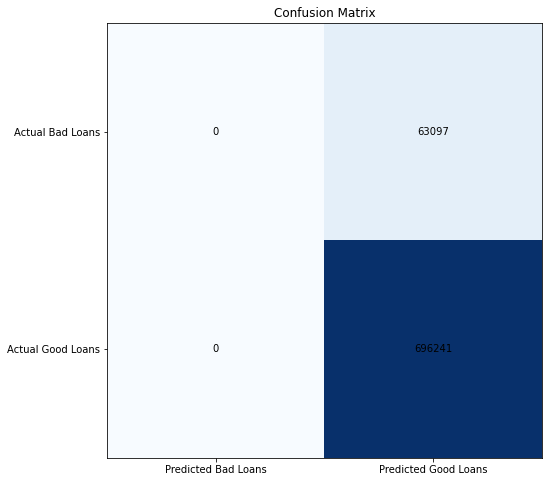

In [17]:
#https://www.w3resource.com/python-exercises/pandas/python-pandas-data-series-exercise-9.php
intRateArray = np.array(data['int_rate'].values.tolist())
intRateArray = intRateArray.reshape(-1, 1)


loanGoodnessArray = np.array(data['loanGoodness'].values.tolist())
loanGoodnessArray[loanGoodnessArray == 'Good'] = 1
loanGoodnessArray[loanGoodnessArray == 'Bad'] = 0


#https://realpython.com/logistic-regression-python/
model = LogisticRegression(solver='liblinear', random_state=0)
model.fit(intRateArray,loanGoodnessArray)

print('Model coefficient:')
print(model.coef_)

print('Model score (correct prediction):')
print(model.score(intRateArray,loanGoodnessArray))

print('Confusion Matrix:')
confMat = confusion_matrix(loanGoodnessArray,model.predict(intRateArray))
#Copy and paste from https://realpython.com/logistic-regression-python/
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(confMat,cmap='Blues')
ax.grid(False)
ax.xaxis.set(ticks=(0, 1), ticklabels=('Predicted Bad Loans', 'Predicted Good Loans'))
ax.yaxis.set(ticks=(0, 1), ticklabels=('Actual Bad Loans', 'Actual Good Loans'))
ax.set_ylim(1.5, -0.5)
for i in range(2):
    for j in range(2):
        ax.text(j, i, confMat[i, j], ha='center', va='center', color='black')
plt.title('Confusion Matrix')
plt.savefig("confMatrix.pdf", bbox_inches="tight")

## Exploring Hypothesis 3 ##

In [13]:
#Exploring Hypothesis 3

#Source: https://stackoverflow.com/questions/34317149/pandas-groupby-with-bin-counts
purposeGoodnessDf = data.groupby(["purpose","loanGoodness"])
purposeGoodnessDf = purposeGoodnessDf.size().unstack()
purposeGoodnessDf['badnessRate'] = purposeGoodnessDf['Bad']/(purposeGoodnessDf['Bad']+purposeGoodnessDf['Good'])

del purposeGoodnessDf['Good']
del purposeGoodnessDf['Bad']
purposeGoodnessDf

loanGoodness,badnessRate
purpose,
car,0.059246
credit_card,0.068816
debt_consolidation,0.088379
home_improvement,0.072451
house,0.105588
major_purchase,0.082865
medical,0.092085
moving,0.104638
other,0.086148


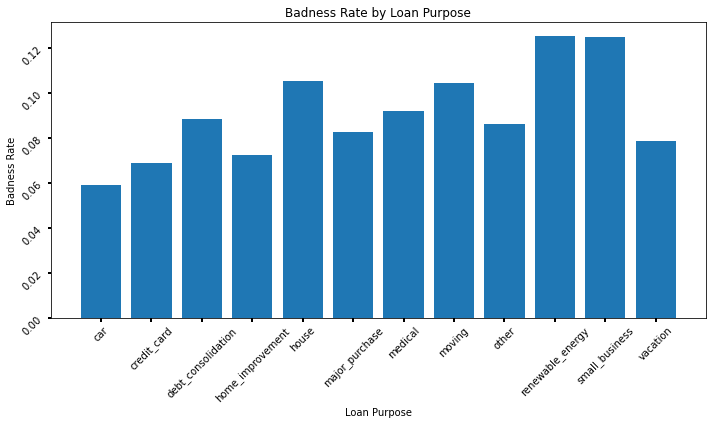

In [14]:
plt.figure(figsize=(10, 6)) 

# flatten array into list
pGList = purposeGoodnessDf.values.tolist()
Goodness_list = []
for sublist in pGList:
    for item in sublist:
        Goodness_list.append(item)
Goodness_list
plt.bar(purposeGoodnessDf.index, Goodness_list, align='center')
plt.ylabel('Badness Rate')
plt.xlabel('Loan Purpose')
plt.title('Badness Rate by Loan Purpose')
plt.tick_params(labelrotation=45, width=2)
plt.tight_layout()
plt.savefig("BadnessByPurpose.pdf")
plt.show()


## Additional Explorations ##

In [15]:
# !!!!! - Heat mapping purpose with loan amount

#Source: https://stackoverflow.com/questions/34317149/pandas-groupby-with-bin-counts
data['loanAmntBin'] = pd.cut(data['loan_amnt'],10)
purposeDf = data.groupby(["purpose","loanAmntBin","loanGoodness"])
purposeDf = purposeDf.size().unstack()
purposeDf['badnessRate'] = purposeDf['Bad']/(purposeDf['Bad']+purposeDf['Good'])
del purposeDf['Good']
del purposeDf['Bad']
purposeDf = purposeDf.unstack()
#purposeDf

purposeDf.style.background_gradient(cmap='Reds')


In [16]:
# !!!!! - Loan Amount

#Source: https://stackoverflow.com/questions/34317149/pandas-groupby-with-bin-counts
loanAmntDf = data.groupby(["loanAmntBin","loanGoodness"])
loanAmntDf = loanAmntDf.size().unstack()
loanAmntDf['badnessRate'] = loanAmntDf['Bad']/(loanAmntDf['Bad']+loanAmntDf['Good'])
loanAmntDf

loanGoodness,Bad,Good,badnessRate
loanAmntBin,,,
"(961.0, 4900.0]",5123,75341,0.063668
"(4900.0, 8800.0]",11379,142535,0.073931
"(8800.0, 12700.0]",12242,143089,0.078812
"(12700.0, 16600.0]",9719,100700,0.088019
"(16600.0, 20500.0]",8030,78281,0.093036
"(20500.0, 24400.0]",4814,45094,0.096457
"(24400.0, 28300.0]",3778,38111,0.090191
"(28300.0, 32200.0]",3337,30387,0.098950
"(32200.0, 36100.0]",4168,32356,0.114117


In [18]:
ptable = data.pivot_table(index='grade', columns='purpose', 
        margins=False, aggfunc='size')
ptable.style.background_gradient(cmap='Blues')

purpose,car,credit_card,debt_consolidation,home_improvement,house,major_purchase,medical,moving,other,renewable_energy,small_business,vacation,wedding
grade,,,,,,,,,,,,,
A,2074.000000,35498.000000,59554.000000,12750.000000,402.000000,3739.000000,1640.000000,660.000000,6216.000000,51.000000,877.000000,1056.000000,nan
B,2774.000000,57130.000000,125641.000000,17279.000000,682.000000,5469.000000,3116.000000,1513.000000,13287.000000,133.000000,1764.000000,2018.000000,1.000000
C,2534.000000,44871.000000,145849.000000,16953.000000,1062.000000,5526.000000,3493.000000,2108.000000,17418.000000,180.000000,2664.000000,2243.000000,2.000000
D,951.000000,13660.000000,60900.000000,6400.000000,664.000000,2212.000000,1376.000000,1034.000000,8338.000000,89.000000,1578.000000,756.000000,nan
E,326.000000,4766.000000,26473.000000,2629.000000,432.000000,927.000000,538.000000,444.000000,3592.000000,43.000000,830.000000,254.000000,nan
F,88.000000,1395.000000,9514.000000,858.000000,197.000000,327.000000,156.000000,152.000000,1243.000000,16.000000,345.000000,71.000000,nan
G,30.000000,448.000000,3599.000000,328.000000,122.000000,119.000000,41.000000,62.000000,586.000000,7.000000,177.000000,18.000000,nan
